In [ ]:
import pysam
import matplotlib.pyplot as plt
import tinycov


ModuleNotFoundError: No module named 'pysam'

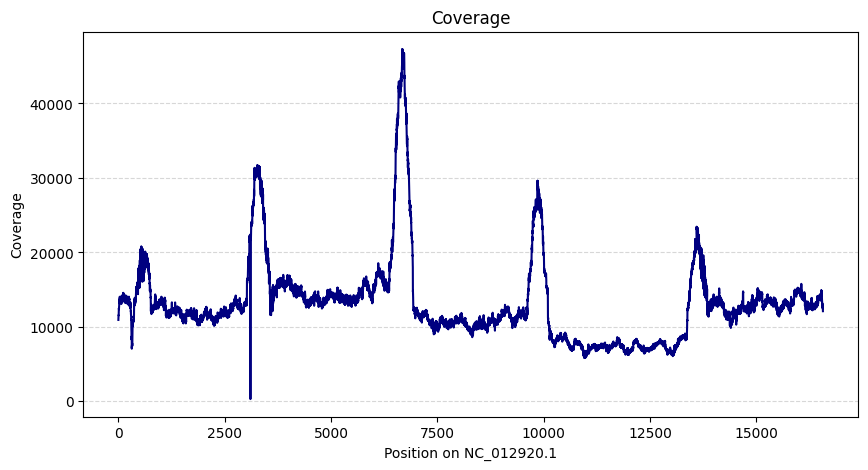

In [ ]:
#creating a coverage plot for a single BAM file
bam_path = "/mnt/claw-raid/elliot/3842_003_sorted.bam"
chrom = "NC_012920.1"  # mitochondrial genome

bam = pysam.AlignmentFile(bam_path, "rb")
mt_length = bam.get_reference_length(chrom)
coverage = [sum(x) for x in zip(*bam.count_coverage(chrom, start=0, end=mt_length))]
bam.close()

plt.figure(figsize=(10,5))
plt.plot(coverage, color="navy")
plt.title("Coverage")
plt.xlabel("Position on NC_012920.1")
plt.ylabel("Coverage")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

ValueError: file does not contain alignment data

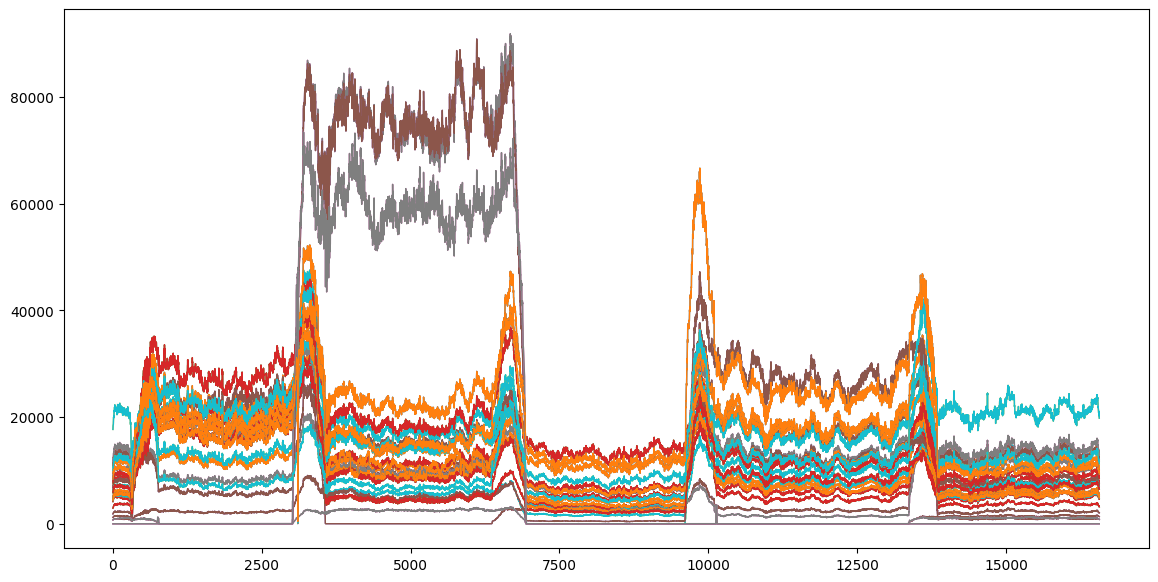

In [15]:
import pysam
import matplotlib.pyplot as plt
import glob
import os
import re

# Directory containing BAM files
bam_dir = "/mnt/claw-raid/elliot/"
chrom = "NC_012920.1"  # mitochondrial genome

# Find all sorted BAM files matching the pattern
bam_files = sorted(glob.glob(os.path.join(bam_dir, "3842_*_sorted.bam")))

plt.figure(figsize=(14, 7))

for bam_path in bam_files:
    # Extract cell number from filename
    match = re.search(r"3842_(\d+)_sorted\.bam", os.path.basename(bam_path))
    label = f"Cell{match.group(1)}" if match else os.path.basename(bam_path)
    
    bam = pysam.AlignmentFile(bam_path, "rb")
    mt_length = bam.get_reference_length(chrom)
    coverage = [sum(x) for x in zip(*bam.count_coverage(chrom, start=0, end=mt_length))]
    bam.close()
    
    plt.plot(coverage, label=label, linewidth=1)  # Thinner lines

plt.title("Mitochondrial Genome Coverage for Multiple Cells")
plt.xlabel("Position on NC_012920.1")
plt.ylabel("Coverage")
plt.legend(fontsize=8, ncol=2, title="Cells")  # Smaller legend, 2 columns
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.yticks(range(0, int(plt.ylim()[1])+1, 500))  # Y axis ticks every 500
plt.tight_layout()
plt.show()

Index(['ID', 'Filter', 'Pos', 'Ref', 'Variant', 'VariantLevel',
       'MeanBaseQuality', 'Coverage', 'GT', 'Type', 'Mutation', 'Substitution',
       'Maplocus', 'Category', 'Phylotree17_haplogroups', 'Phylotree17_clades',
       'HaploGrep2_weight', 'RSRS_SNP', 'KGP3_SNP', 'AAC', 'CodonPosition',
       'AminoAcid', 'NewAminoAcid', 'AminoAcid_pos_protein', 'MutPred_Score',
       'mtDNA_Selection_Score', 'CI_MitoTool', 'OXPHOS_complex',
       'NuMTs_dayama', 'Helix_count_hom', 'Helix_count_het', 'Helix_vaf_hom',
       'Helix_vaf_het', 'Helix_haplogroups', 'rCRS_Surr_seq',
       'LowComplexityRegion', 'DuplSeq_rCRS', 'DuplSeq_rCRS_pos'],
      dtype='object')


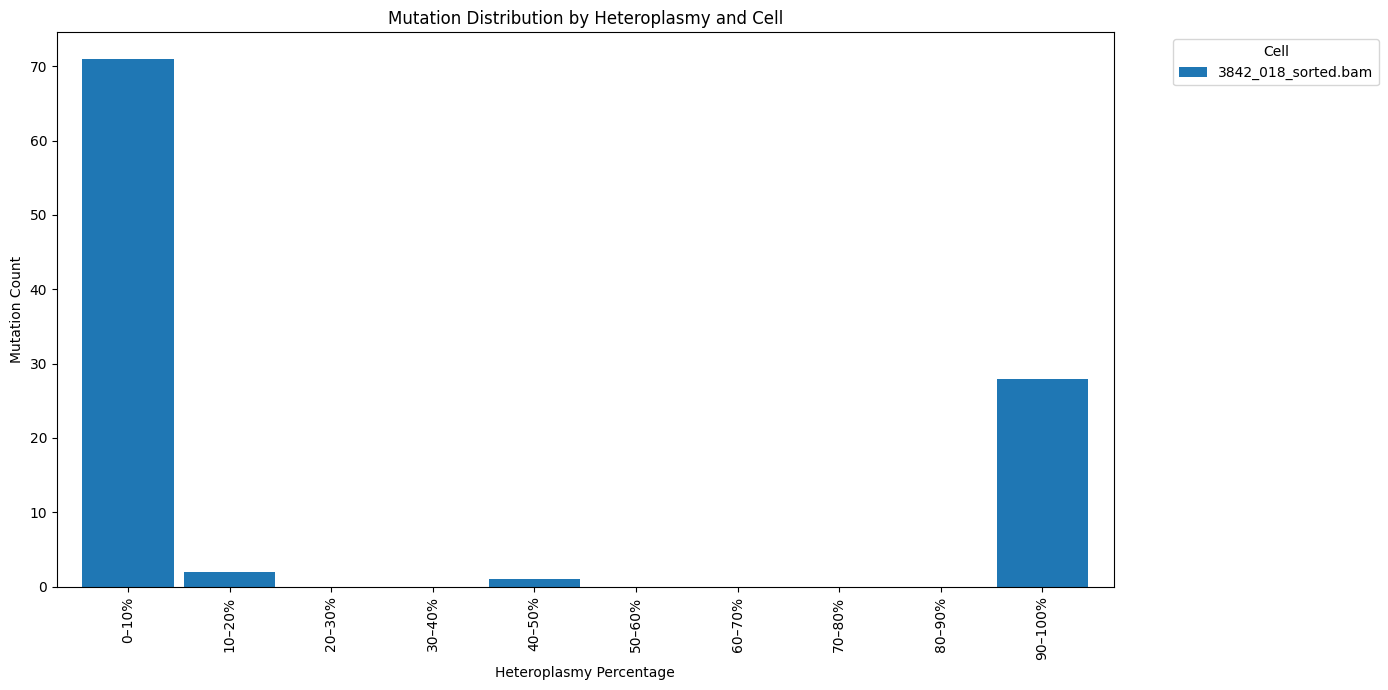

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the annotated variants file with the full path
df = pd.read_csv("/mnt/claw-raid/elliot/variants.annotated.txt", sep="\t")

# Print column names to check
print(df.columns)

# Set your actual column names here:
cell_col = "ID"                # Use "ID" for cell/sample column in your file
het_col = "VariantLevel"       # Use "VariantLevel" for heteroplasmy column

# Bin heteroplasmy (0-10%, 10-20%, ..., 90-100%)
bins = np.arange(0, 110, 10)
labels = [f"{b:.0f}–{b+10:.0f}%" for b in bins[:-1]]
df["het_bin"] = pd.cut(df[het_col]*100, bins=bins, labels=labels, right=False)

# Count mutations per cell per bin
mutation_counts = df.groupby([cell_col, "het_bin"]).size().unstack(fill_value=0)

# Plot
mutation_counts.T.plot(kind="bar", figsize=(14,7), width=0.9)
plt.xlabel("Heteroplasmy Percentage")
plt.ylabel("Mutation Count")
plt.title("Mutation Distribution by Heteroplasmy and Cell")
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Loading files matching: /mnt/claw-raid/elliot/variants.annotatedCell*.txt
Loaded 3844 variants from 21 cells
After filtering: 2630 variants (Coverage ≥500, Heteroplasmy ≥5.0%)
Analyzing 17 cells with ≤100 mutations each


/tmp/ipykernel_2404826/3043486675.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", n_cells)(range(n_cells))


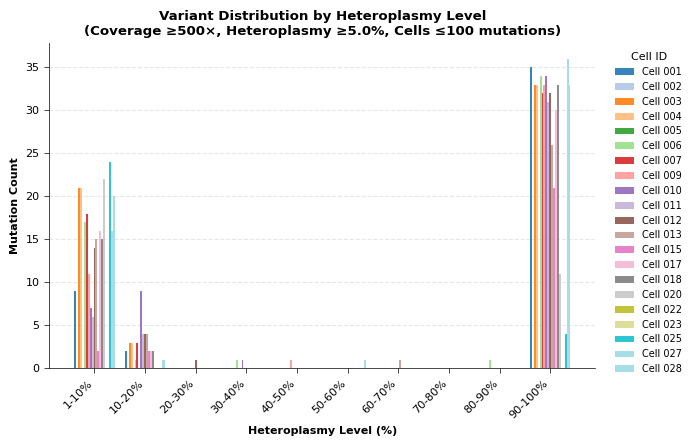

Plot saved to: mutation_distribution.png

Total cells: 21
Total mutations: 793

Mutations by heteroplasmy level:
  1-10%: 254
  10-20%: 41
  20-30%: 1
  30-40%: 2
  40-50%: 1
  50-60%: 1
  60-70%: 1
  70-80%: 0
  80-90%: 1
  90-100%: 491


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from matplotlib import cm

# Configuration
FILE_PATTERN = "/mnt/claw-raid/elliot/variants.annotatedCell*.txt"
MIN_COVERAGE = 500
MIN_HETEROPLASMY = 5.0
MAX_MUTATIONS_PER_CELL = 100
OUTPUT_FILE = "mutation_distribution.png"

# Heteroplasmy bins
BINS = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
BIN_LABELS = ["1-10%", "10-20%", "20-30%", "30-40%", "40-50%", 
              "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]

# Load all files
print(f"Loading files matching: {FILE_PATTERN}")
file_list = glob.glob(FILE_PATTERN)
if not file_list:
    raise FileNotFoundError(f"No files found matching pattern: {FILE_PATTERN}")

all_dfs = []
for file in file_list:
    df = pd.read_csv(file, sep="\t")
    cell_id = file.split("Cell")[-1].replace(".txt", "")
    df["Cell"] = cell_id
    all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)
all_cells = sorted(df_all["Cell"].unique())
print(f"Loaded {len(df_all)} variants from {len(all_cells)} cells")

# Convert to numeric and handle errors
df_all["VariantLevel"] = pd.to_numeric(df_all["VariantLevel"], errors="coerce")
df_all["Coverage"] = pd.to_numeric(df_all["Coverage"], errors="coerce")
df_all = df_all.dropna(subset=["VariantLevel", "Coverage"])

# Convert to percentage if needed
if df_all["VariantLevel"].max() <= 1.0:
    df_all["VariantLevel"] = df_all["VariantLevel"] * 100

# Filter by coverage and heteroplasmy
df_filtered = df_all[(df_all["Coverage"] >= MIN_COVERAGE) & 
                      (df_all["VariantLevel"] >= MIN_HETEROPLASMY) &
                      (df_all["VariantLevel"] <= 100)].copy()
print(f"After filtering: {len(df_filtered)} variants (Coverage ≥{MIN_COVERAGE}, Heteroplasmy ≥{MIN_HETEROPLASMY}%)")

# Bin heteroplasmy levels
df_filtered["het_bin"] = pd.cut(df_filtered["VariantLevel"], 
                                 bins=BINS, 
                                 labels=BIN_LABELS, 
                                 right=True,
                                 include_lowest=True)

# Count mutations per cell and bin (include all cells, even with 0 variants)
mutation_counts = df_filtered.groupby(["Cell", "het_bin"], observed=True).size().unstack(fill_value=0)
mutation_counts = mutation_counts.reindex(columns=BIN_LABELS, fill_value=0)
mutation_counts = mutation_counts.reindex(index=all_cells, fill_value=0)

# Keep all cells for legend
cells_for_plot = mutation_counts.index.copy()

# Remove cells with too many mutations
mutation_counts = mutation_counts[mutation_counts.sum(axis=1) <= MAX_MUTATIONS_PER_CELL]
mutation_counts = mutation_counts.sort_index()
print(f"Analyzing {len(mutation_counts)} cells with ≤{MAX_MUTATIONS_PER_CELL} mutations each")

# Plot
n_cells = len(cells_for_plot)
colors = plt.cm.get_cmap("tab20", n_cells)(range(n_cells))

fig, ax = plt.subplots(figsize=(7, 4.5))
x = np.arange(len(BIN_LABELS))
width = 0.8 / n_cells

# Plot all cells (even empty)
for i, cell in enumerate(cells_for_plot):
    if cell in mutation_counts.index:
        counts = mutation_counts.loc[cell]
    else:
        counts = np.zeros(len(BIN_LABELS))
    offset = (i - n_cells/2) * width + width/2
    ax.bar(x + offset, counts, width=width, 
           label=f'Cell {cell}', color=colors[i], alpha=0.9)

ax.set_xlabel('Heteroplasmy Level (%)', fontweight='bold')
ax.set_ylabel('Mutation Count', fontweight='bold')
ax.set_title(f'Variant Distribution by Heteroplasmy Level\n(Coverage ≥{MIN_COVERAGE}×, Heteroplasmy ≥{MIN_HETEROPLASMY}%, Cells ≤{MAX_MUTATIONS_PER_CELL} mutations)', 
             fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(BIN_LABELS, rotation=45, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Cell ID', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved to: {OUTPUT_FILE}")

# Summary
print(f"\nTotal cells: {len(cells_for_plot)}")
print(f"Total mutations: {int(mutation_counts.sum().sum())}")
print("\nMutations by heteroplasmy level:")
for bin_label in BIN_LABELS:
    count = int(mutation_counts[bin_label].sum())
    print(f"  {bin_label}: {count}")


In [57]:
#  Imports & Configuration 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import glob

# --- Configuration ---
CONFIG = {
    'variant_pattern': "/mnt/claw-raid/elliot/variants.annotatedCell*.txt",
    'haplo_pattern': "/mnt/claw-raid/elliot/haplogroupsCell*.txt",
    'min_coverage': 500,
    'min_heteroplasmy': 1.0,
    'max_mutation_freq': 100,
    'output_base': "mutation_distribution",
    'bins': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'y_limit': 100,
    'haplo_flip_threshold': 95.0,  # Flip variants above this VAF
}

print("✅ Configuration loaded")


✅ Configuration loaded


In [58]:
# === Cell 2: Helper Functions ===

def extract_cell_id(filepath):
    """Extract cell ID from filename (e.g., 'Cell001')."""
    match = re.search(r"Cell(\d+)", Path(filepath).name)
    return f"Cell{int(match.group(1)):03d}" if match else None


def load_variants(filepath):
    """Load and process a variant file."""
    df = pd.read_csv(filepath, sep='\t')

    # Ensure numeric
    df['variant_level'] = pd.to_numeric(df['VariantLevel'], errors='coerce')
    df['coverage'] = pd.to_numeric(df['Coverage'], errors='coerce')
    df['Pos'] = pd.to_numeric(df.get('Pos', np.nan), errors='coerce')

    df = df.dropna(subset=['variant_level', 'coverage'])

    # SIMPLE FIX: Check if values need scaling
    sample_values = df['variant_level'].head(5)  # Check first 5 values
    if all(0 <= v <= 1 for v in sample_values if not pd.isna(v)):
        df['variant_level'] = df['variant_level'] * 100
        print(f"   Scaled heteroplasmy values to percentage for {Path(filepath).name}")

    # Add identifiers
    df['pos_allele'] = df['Pos'].astype(str) + df['Variant'].str.upper()
    df['gene'] = df.get('Maplocus', 'Unknown')
    df['complex'] = df.get('OXPHOS_complex', '').fillna('Non-coding').replace('', 'Non-coding')

    return df


def get_haplogroup_variants(filepath):
    """Extract haplogroup variants (e.g., 1234A) from a haplogroup file."""
    try:
        df = pd.read_csv(filepath, sep='\t')
        variants = set()
        for col in ['Found_Polys', 'Remaining_Polys']:
            if col in df.columns:
                for val in df[col].dropna():
                    variants.update(re.findall(r'\d+[ACGT]', str(val).upper()))
        return variants
    except Exception:
        return set()


def create_stacked_bar(data, x_labels, title, xlabel, output_file, figsize=(12, 6)):
    """Create a stacked bar chart."""
    fig, ax = plt.subplots(figsize=figsize)
    n_cells = len(data.index)
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, n_cells))) if n_cells <= 20 else \
             plt.cm.rainbow(np.linspace(0, 1, n_cells))

    x = np.arange(len(x_labels))
    bottom = np.zeros(len(x_labels))

    for i, cell_id in enumerate(data.index):
        counts = data.loc[cell_id].values
        ax.bar(x, counts, bottom=bottom, label=cell_id, color=colors[i % len(colors)],
               alpha=0.9, width=0.8)
        bottom += counts

    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel('Mutation Count', fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45 if len(x_labels) > 10 else 0, ha='right')
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)

    ncol = 2 if n_cells > 15 else 1
    fontsize = 6 if n_cells > 15 else 8
    ax.legend(title='Cell ID', bbox_to_anchor=(1.02, 1), loc='upper left',
              frameon=False, fontsize=fontsize, ncol=ncol)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    return fig


In [116]:
# === Load and process variants with haplogroup marker flipping ===
variant_files = sorted(glob.glob(CONFIG['variant_pattern']))
haplo_files = {extract_cell_id(f): f for f in glob.glob(CONFIG['haplo_pattern'])}
all_data, all_cells = [], []

for vf in variant_files:
    cell_id = extract_cell_id(vf)
    if not cell_id:
        continue
    
    df = load_variants(vf)
    df['cell_id'] = cell_id
    df['is_flipped'] = False
    df['original_variant_level'] = df['variant_level'].copy()
    
    # Apply coverage filter
    df = df[df['coverage'] >= CONFIG['min_coverage']]
    
    # Flip haplogroup markers >95%
    if cell_id in haplo_files:
        haplo_vars = get_haplogroup_variants(haplo_files[cell_id])
        should_flip = df['pos_allele'].isin(haplo_vars) & (df['variant_level'] > 95.0)
        df.loc[should_flip, 'variant_level'] = 100 - df.loc[should_flip, 'variant_level']
        df.loc[should_flip, 'is_flipped'] = True
    
    # Apply VAF filter (keep flipped variants even if <1%)
    df = df[(df['variant_level'] >= 1.0) | (df['is_flipped'] == True)]
    
    if len(df) > 0:
        all_data.append(df)
        all_cells.append(cell_id)

df_all = pd.concat(all_data, ignore_index=True)
print(f"Processed {len(all_cells)} cells, {len(df_all)} variants ({df_all['is_flipped'].sum()} flipped)")

   Scaled heteroplasmy values to percentage for variants.annotatedCell001.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell003.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell004.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell006.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell007.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell009.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell010.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell011.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell012.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell013.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell015.txt
   Scaled heteroplasmy values to percentage for variants.annotatedCell017.txt
   Scaled heteroplasmy values to percentage for variants.annotat

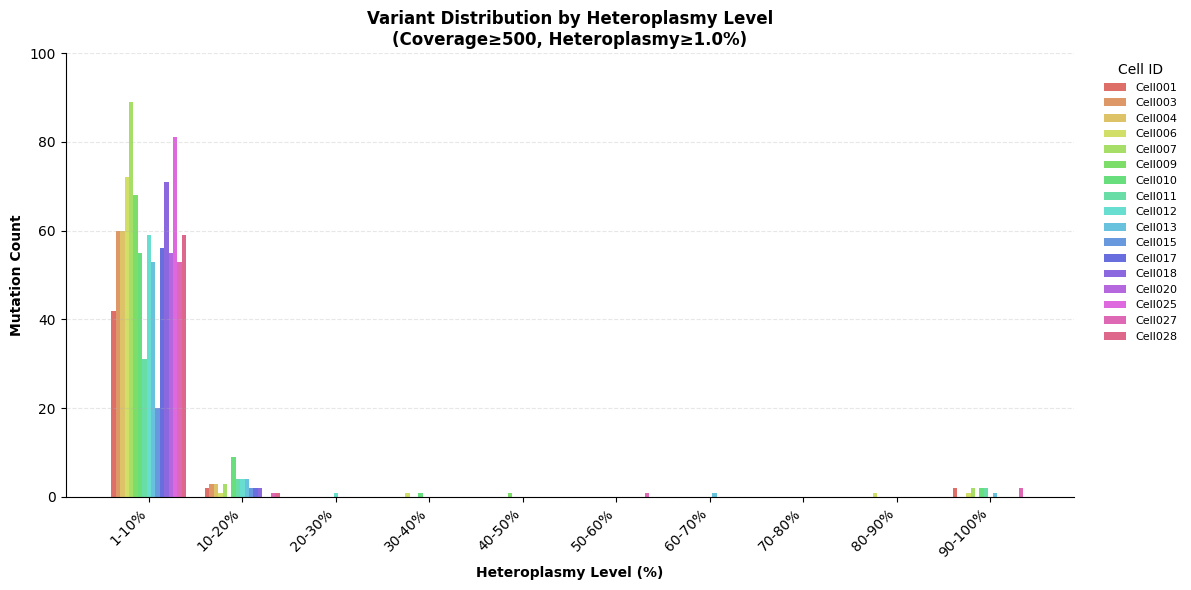

In [117]:
import seaborn as sns

# === Cell 4: Plot 1 — Heteroplasmy Distribution ===

bin_labels = [f"{CONFIG['bins'][i]}-{CONFIG['bins'][i+1]}%" 
              for i in range(len(CONFIG['bins']) - 1)]

df_all['het_bin'] = pd.cut(df_all['variant_level'],
                           bins=CONFIG['bins'],
                           labels=bin_labels,
                           include_lowest=True)

mutation_counts = df_all.groupby(['cell_id', 'het_bin'], observed=True).size().unstack(fill_value=0)
mutation_counts = mutation_counts.reindex(columns=bin_labels, fill_value=0)
mutation_counts = mutation_counts.reindex(index=all_cells, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
n_cells = len(mutation_counts)
colors = sns.color_palette("hls", n_cells)  # one distinct color per cell

x = np.arange(len(bin_labels))
width = 0.8 / n_cells

for i, cell_id in enumerate(mutation_counts.index):
    offset = (i - n_cells / 2) * width + width / 2
    ax.bar(x + offset, mutation_counts.loc[cell_id], width=width,
           label=cell_id, color=colors[i % len(colors)], alpha=0.9)

ax.set_xlabel('Heteroplasmy Level (%)', fontweight='bold')
ax.set_ylabel('Mutation Count', fontweight='bold')
ax.set_title(f'Variant Distribution by Heteroplasmy Level\n(Coverage≥{CONFIG["min_coverage"]}, Heteroplasmy≥{CONFIG["min_heteroplasmy"]}%)',
             fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_ylim(0, CONFIG['y_limit'])
ax.spines[['top', 'right']].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.legend(title='Cell ID', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig(f"{CONFIG['output_base']}.png", dpi=300, bbox_inches='tight')
plt.show()


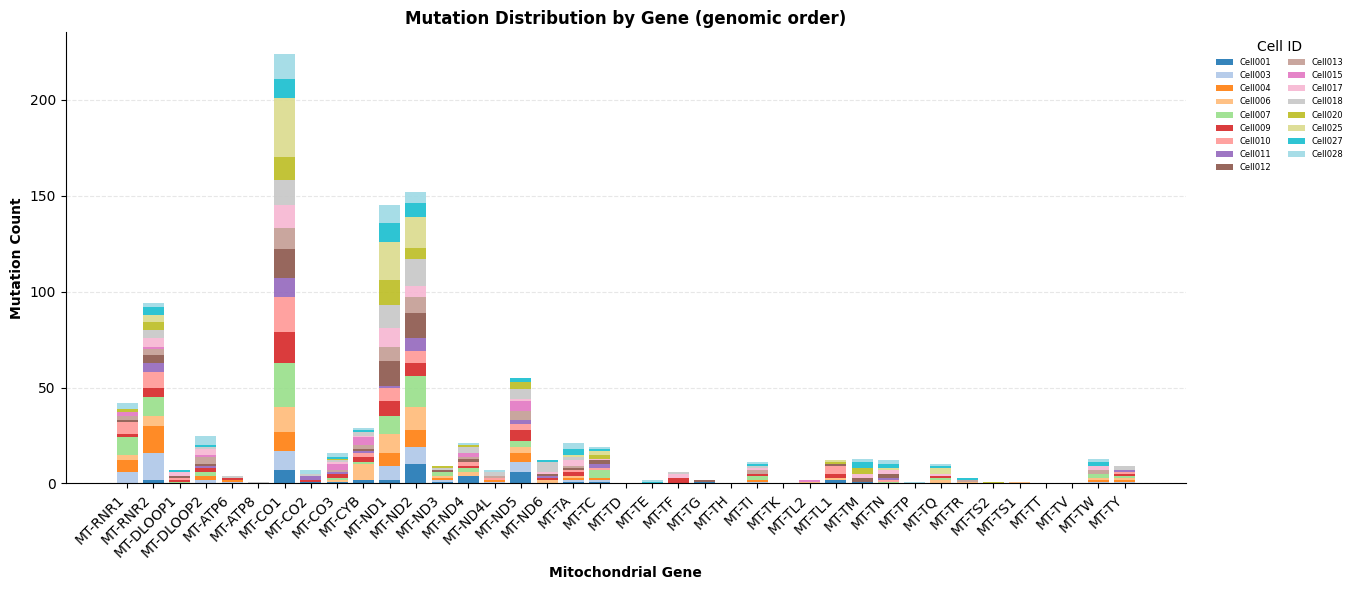

In [108]:
gene_counts = df_all.groupby(['cell_id', 'gene'], observed=True).size().unstack(fill_value=0)

# Hardcoded genomic order
gene_order = [
    'MT-RNR1', 'MT-RNR2', 'MT-DLOOP1', 'MT-DLOOP2', 'MT-ATP6', 'MT-ATP8', 
    'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 
    'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-TA', 'MT-TC', 'MT-TD', 
    'MT-TE', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI', 'MT-TK', 'MT-TL2', 
    'MT-TL1', 'MT-TM', 'MT-TN', 'MT-TP', 'MT-TQ', 'MT-TR', 'MT-TS2', 
    'MT-TS1', 'MT-TT', 'MT-TV', 'MT-TW', 'MT-TY'
]

# Use reindex to ensure all genes are present, filling missing ones with 0
gene_counts = gene_counts.reindex(columns=gene_order, fill_value=0)

create_stacked_bar(
    gene_counts,
    gene_counts.columns.tolist(),
    f'Mutation Distribution by Gene (genomic order)',
    'Mitochondrial Gene',
    f"{CONFIG['output_base']}_by_gene.png",
    figsize=(max(12, len(gene_counts.columns) * 0.35), 6)
)
plt.show()

In [107]:
print(df_all['gene'].unique())


[nan 'MT-RNR2' 'MT-TL1' 'MT-ND1' 'MT-TM' 'MT-ND2' 'MT-TA' 'MT-TC' 'MT-CO1'
 'MT-CO2' 'MT-CO3' 'MT-TG' 'MT-ND3' 'MT-ND4' 'MT-ND5' 'MT-CYB' 'MT-DLOOP2'
 'MT-RNR1' 'MT-TI' 'MT-TW' 'MT-TY' 'MT-ATP6' 'MT-ND4L' 'MT-TQ' 'MT-TS1'
 'MT-TR' 'MT-TL2' 'MT-ND6' 'MT-TN' 'MT-DLOOP1' 'MT-TF' 'MT-ATP8' 'MT-TS2'
 'MT-TE' 'MT-TP']


In [72]:
# === Cell 7: Display simplified pathogenic variants ===

# Filter for pathogenic variants (MutPred > 0.5)
pathogenic_df = df_all[df_all['MutPred_Score'] > 0.5].copy()

# Build simple columns
pathogenic_df['DNA_change'] = pathogenic_df['Pos'].astype(str) + pathogenic_df['Ref'] + ">" + pathogenic_df['Variant']
pathogenic_df['AA_change'] = pathogenic_df['AminoAcid'].fillna('') + ">" + pathogenic_df['NewAminoAcid'].fillna('')

# Select desired columns
columns_to_show = ['cell_id', 'DNA_change', 'AA_change', 'MutPred_Score', 'OXPHOS_complex']
display_df = pathogenic_df[columns_to_show]

# Output to command line
print(display_df.to_string(index=False))


cell_id DNA_change AA_change  MutPred_Score OXPHOS_complex
Cell001    3484C>T       P>S          0.665              I
Cell001    3515T>C       L>P          0.738              I
Cell001    4522T>C       L>P          0.687              I
Cell001    4597T>C       V>A          0.669              I
Cell001    4878G>A       A>T          0.746              I
Cell001    5205T>C       S>P          0.512              I
Cell001    5464T>C       L>P          0.714              I
Cell001    6031A>G       Q>R          0.718             IV
Cell001    6070T>G       V>G          0.622             IV
Cell001    6301C>T       A>V          0.813             IV
Cell001    6325C>T       A>V          0.686             IV
Cell001    6478C>T       A>V          0.748             IV
Cell001    6796A>G       D>G          0.777             IV
Cell001    7691T>C       F>L          0.602             IV
Cell001    9288A>G       T>A          0.615             IV
Cell001   10372A>G       E>G          0.816             

In [103]:
print(df_all['gene'].unique())



[nan 'MT-RNR2' 'MT-TL1' 'MT-ND1' 'MT-TM' 'MT-ND2' 'MT-TA' 'MT-TC' 'MT-CO1'
 'MT-CO2' 'MT-CO3' 'MT-TG' 'MT-ND3' 'MT-ND4' 'MT-ND5' 'MT-CYB' 'MT-DLOOP2'
 'MT-RNR1' 'MT-TI' 'MT-TW' 'MT-TY' 'MT-ATP6' 'MT-ND4L' 'MT-TQ' 'MT-TS1'
 'MT-TR' 'MT-TL2' 'MT-ND6' 'MT-TN' 'MT-DLOOP1' 'MT-TF' 'MT-ATP8' 'MT-TS2'
 'MT-TE' 'MT-TP']


In [70]:
import pandas as pd

def compare_cell_groups(df_all):
    """Simple comparison between cells 1-20 and cells >20"""
    
    # Get cell numbers
    df_all['cell_num'] = df_all['cell_id'].str.extract('Cell(\d+)').astype(int)
    
    # Split into two groups
    group1 = df_all[df_all['cell_num'] <= 20]
    group2 = df_all[df_all['cell_num'] > 20]
    
    print("=== SIMPLE COMPARISON ===")
    print(f"Cells 1-20: {len(group1)} variants in {group1['cell_id'].nunique()} cells")
    print(f"Cells >20: {len(group2)} variants in {group2['cell_id'].nunique()} cells")
    
    # Basic stats
    print(f"\n--- AVERAGES ---")
    print(f"Variants per cell:")
    print(f"  Cells 1-20: {len(group1)/group1['cell_id'].nunique():.1f}")
    print(f"  Cells >20: {len(group2)/group2['cell_id'].nunique():.1f}")
    
    print(f"\nHeteroplasmy levels:")
    print(f"  Cells 1-20: {group1['variant_level'].mean():.1f}%")
    print(f"  Cells >20: {group2['variant_level'].mean():.1f}%")
    
    # Most common genes
    print(f"\n--- TOP 3 GENES ---")
    for name, group in [('Cells 1-20', group1), ('Cells >20', group2)]:
        top_genes = group['gene'].value_counts().head(3)
        print(f"\n{name}:")
        for gene, count in top_genes.items():
            print(f"  {gene}: {count} variants")
    
    return group1, group2

# Run it
group1, group2 = compare_cell_groups(df_all)

=== SIMPLE COMPARISON ===
Cells 1-20: 841 variants in 14 cells
Cells >20: 198 variants in 3 cells

--- AVERAGES ---
Variants per cell:
  Cells 1-20: 60.1
  Cells >20: 66.0

Heteroplasmy levels:
  Cells 1-20: 5.7%
  Cells >20: 5.5%

--- TOP 3 GENES ---

Cells 1-20:
  MT-CO1: 170 variants
  MT-ND2: 123 variants
  MT-ND1: 106 variants

Cells >20:
  MT-CO1: 54 variants
  MT-ND1: 39 variants
  MT-ND2: 29 variants


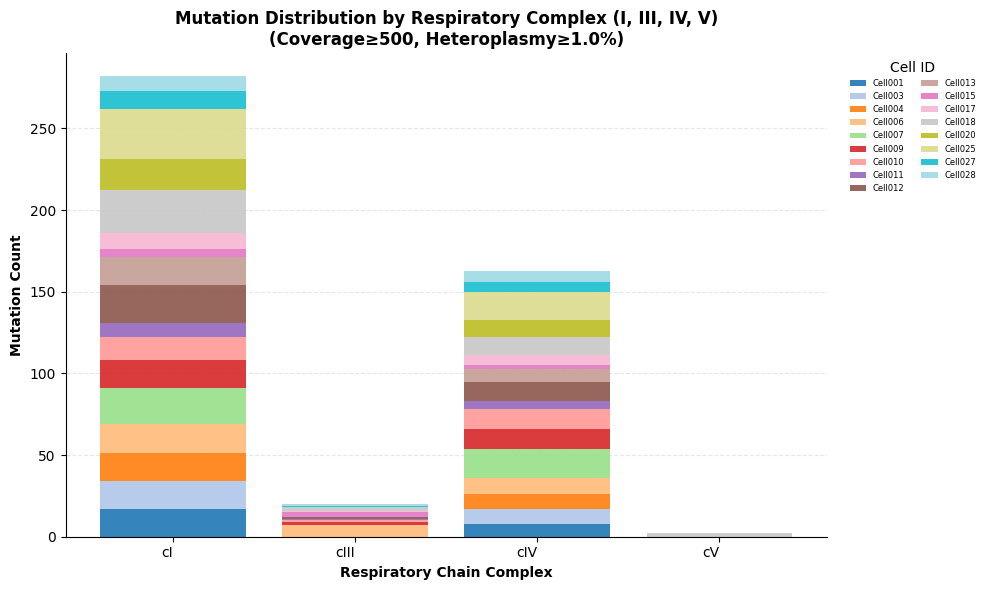

In [71]:
# Filter only variants in OXPHOS complex genes (I, III, IV, V)
df_resp = df_all[df_all['OXPHOS_complex'].notna()].copy()
if df_resp.empty:
    print("⚠️ No variants affecting respiratory complex proteins in filtered data.")
else:
    # Use the OXPHOS_complex column directly
    df_resp['complex'] = df_resp['OXPHOS_complex']
    
    # Standardize complex naming to match your expected format
    complex_mapping = {
        'I': 'cI', 'III': 'cIII', 'IV': 'cIV', 'V': 'cV',
        'CI': 'cI', 'CIII': 'cIII', 'CIV': 'cIV', 'CV': 'cV',
        'Complex I': 'cI', 'Complex III': 'cIII', 'Complex IV': 'cIV', 'Complex V': 'cV'
    }
    df_resp['complex'] = df_resp['complex'].map(complex_mapping).fillna(df_resp['complex'])

    # Group by cell × complex
    complex_counts = df_resp.groupby(['cell_id','complex'], observed=True).size().unstack(fill_value=0)
    complex_counts = complex_counts.reindex(index=all_cells, fill_value=0)

    # Ensure only the relevant complexes are included in the plot
    relevant_complexes = ['cI','cIII','cIV','cV']
    complex_counts = complex_counts.reindex(columns=relevant_complexes, fill_value=0)

    # Plot
    create_stacked_bar(
        complex_counts,
        complex_counts.columns,
        f'Mutation Distribution by Respiratory Complex (I, III, IV, V)\n(Coverage≥{CONFIG["min_coverage"]}, Heteroplasmy≥{CONFIG["min_heteroplasmy"]}%)',
        'Respiratory Chain Complex',
        f"{CONFIG['output_base']}_by_complex.png",
        figsize=(10,6)
    )
    plt.show()